In [1]:
###### %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# convolutional autoencoder in keras

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"

from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
# %matplotlib inline

from keras.datasets import mnist 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def own_kullback_leibler_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

def own_mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def own_loss(y_true, y_pred):
    return 1.0*own_kullback_leibler_divergence(y_true, y_pred)+own_mean_squared_error(y_true, y_pred)

# utility function for showing images
def show_imgs(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()


### Create input
    
input_img = Input(shape=(28, 28,1)) # 1ch=black&white, 28 x 28

(x_all, y_all), (x_all_test, y_all_test) = mnist.load_data()

x_all = x_all.astype('float32')/255. # 0-1.に変換
x_all_test = x_all_test.astype('float32')/255.

###

x_9_list=[]
for i in range(len(y_all)):
    if (y_all[i] == 9):
        x_9_list.append(x_all[i])
x_9=np.asarray(x_9_list[:5000])
x_9_list_test=[]
for i in range(len(y_all_test)):
    if (y_all_test[i] == 9):
        x_9_list_test.append(x_all_test[i])
x_9_test=np.asarray(x_9_list_test[:500])

###

x_6_list=[]
for i in range(len(y_all)):
    if (y_all[i] == 6):
        x_6_list.append(x_all[i])
x_6=np.asarray(x_6_list[:5000])
x_6_list_test=[]
for i in range(len(y_all_test)):
    if (y_all_test[i] == 6):
        x_6_list_test.append(x_all_test[i])
x_6_test=np.asarray(x_6_list_test[:500])

###

x_8_list=[]
for i in range(len(y_all)):
    if (y_all[i] == 8):
        x_8_list.append(x_all[i])
x_8=np.asarray(x_8_list[:5000])
x_8_list_test=[]
for i in range(len(y_all_test)):
    if (y_all_test[i] == 8):
        x_8_list_test.append(x_all_test[i])
x_8_test=np.asarray(x_8_list_test[:500])

###

x_9 = np.reshape(x_9, (len(x_9), 28, 28, 1))
x_9_test = np.reshape(x_9_test, (len(x_9_test), 28, 28, 1))

x_6 = np.reshape(x_6, (len(x_6), 28, 28, 1))
x_6_test = np.reshape(x_6_test, (len(x_6_test), 28, 28, 1))

x_8 = np.reshape(x_8, (len(x_8), 28, 28, 1))
x_8_test = np.reshape(x_8_test, (len(x_8_test), 28, 28, 1))

print(x_9.shape,x_6.shape,x_8.shape)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(5000, 28, 28, 1) (5000, 28, 28, 1) (5000, 28, 28, 1)


In [2]:
### pretrain outer layers

train1_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='t1c1')(input_img) #nb_filter, nb_row, nb_col

train1_decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same', name='t1d1')(train1_conv1)

input1_train1_autoencoder = Model(input_img, train1_decoded)
input1_train1_autoencoder.compile(optimizer='adadelta', loss=own_loss)

input2_train1_autoencoder = Model(input_img, train1_decoded)
input2_train1_autoencoder.compile(optimizer='adadelta', loss=own_loss)

input1_train1_autoencoder.fit(x_9, x_9, epochs=10, batch_size=20,
               shuffle=True, validation_data=(x_9_test, x_9_test), verbose=1)

input2_train1_autoencoder.fit(x_8, x_8, epochs=10, batch_size=20,
               shuffle=True, validation_data=(x_8_test, x_8_test), verbose=1)

# create input for inner pretrain

input1_creator_train2 = Model(input_img, train1_conv1)
for i in range(2):
    input1_creator_train2.layers[i].set_weights(input1_train1_autoencoder.layers[i].get_weights())
    
input2_creator_train2 = Model(input_img, train1_conv1)
for i in range(2):
    input2_creator_train2.layers[i].set_weights(input2_train1_autoencoder.layers[i].get_weights())

input1_train2 = input1_creator_train2.predict(x_9)
input2_train2 = input2_creator_train2.predict(x_8)

print(input1_train2.shape)
print(input2_train2.shape)

# inner pretrain

input_img_train2 = Input(shape=(28, 28,16))

train2_pool1 = MaxPooling2D(pool_size=(2, 2), name='t2p1')(input_img_train2)
train2_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same', name='t2c1')(train2_pool1) #nb_filter, nb_row, nb_col

#---

train2_pool2 = UpSampling2D(size=(2, 2), name='t2p2')(train2_conv1)
train2_decoded = Conv2D(16, (3, 3), activation='relu', padding='same', name='t2d1')(train2_pool2)

input1_train2_autoencoder = Model(input_img_train2, train2_decoded)
input1_train2_autoencoder.compile(optimizer='adadelta', loss=own_loss)

input2_train2_autoencoder = Model(input_img_train2, train2_decoded)
input2_train2_autoencoder.compile(optimizer='adadelta', loss=own_loss)

input1_train2_autoencoder.fit(input1_train2, input1_train2, epochs=10, batch_size=20, verbose=1)
input2_train2_autoencoder.fit(input2_train2, input2_train2, epochs=10, batch_size=20, verbose=1)

Train on 5000 samples, validate on 500 samples
Epoch 1/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0299 - val_loss: -0.0074
Epoch 2/10
5000/5000 [==============================] - 10s 2ms/step - loss: -0.0086 - val_loss: -0.0094
Epoch 3/10
5000/5000 [==============================] - 10s 2ms/step - loss: -0.0097 - val_loss: -0.0101
Epoch 4/10
5000/5000 [==============================] - 10s 2ms/step - loss: -0.0103 - val_loss: -0.0105
Epoch 5/10
5000/5000 [==============================] - 10s 2ms/step - loss: -0.0107 - val_loss: -0.0108
Epoch 6/10
5000/5000 [==============================] - 10s 2ms/step - loss: -0.0109 - val_loss: -0.0110
Epoch 7/10
5000/5000 [==============================] - 10s 2ms/step - loss: -0.0111 - val_loss: -0.0111
Epoch 8/10
5000/5000 [==============================] - 11s 2ms/step - loss: -0.0112 - val_loss: -0.0112
Epoch 9/10
5000/5000 [==============================] - 10s 2ms/step - loss: -0.0113 - val_loss: -0.0113
Epoch 10/

In [3]:
# create input for final pretrain

input1_creator_train3 = Model(input_img_train2, train2_conv1)
for i in range(3):
    input1_creator_train3.layers[i].set_weights(input1_train2_autoencoder.layers[i].get_weights())

input1_train3 = input1_creator_train3.predict(input1_creator_train2.predict(x_9))

print(input1_train3.shape)

input2_creator_train3 = Model(input_img_train2, train2_conv1)
for i in range(3):
    input2_creator_train3.layers[i].set_weights(input1_train2_autoencoder.layers[i].get_weights())

input2_train3 = input2_creator_train3.predict(input2_creator_train2.predict(x_8))

print(input2_train3.shape)

# final pretrain

input1_img_train3 = Input(shape=(14, 14,8))
input2_img_train3 = Input(shape=(14, 14,8))

from keras.layers import average

combine = average([input1_img_train3,input2_img_train3], name='t3combine')
#train3_pool1 = MaxPooling2D(pool_size=(2, 2), name = 't3combinep1')(combine)
train3_conv1 = Conv2D(1, (3, 3), activation='relu', padding='same', name = 't3combinec1')(combine) #nb_filter, nb_row, nb_col

#---

#train3_pool2 = UpSampling2D(size=(2, 2), name = 't3combinep2')(train3_conv1)

input1_train3_decoded = Conv2D(8, (3, 3), activation='relu', padding='same', name = 't3i1c2')(train3_conv1)
input2_train3_decoded = Conv2D(8, (3, 3), activation='relu', padding='same', name = 't3i2c2')(train3_conv1)

train3_autoencoder = Model(inputs=[input1_img_train3,input2_img_train3], outputs=[input1_train3_decoded,input2_train3_decoded])
train3_autoencoder.compile(optimizer='adadelta', loss=[own_loss,own_loss], loss_weights=[1.0,1.0])

train3_autoencoder.fit([input1_train3, input2_train3], [input1_train3, input2_train3], epochs=10, batch_size=20, verbose=1)

(5000, 14, 14, 8)
(5000, 14, 14, 8)
Epoch 1/10
5000/5000 [==============================] - 3s 563us/step - loss: 11.3569 - t3i1c2_loss: 5.4858 - t3i2c2_loss: 5.8711
Epoch 2/10
5000/5000 [==============================] - 3s 507us/step - loss: -0.4017 - t3i1c2_loss: -0.2312 - t3i2c2_loss: -0.1706
Epoch 3/10
5000/5000 [==============================] - 3s 508us/step - loss: -0.6226 - t3i1c2_loss: -0.3279 - t3i2c2_loss: -0.2947
Epoch 4/10
5000/5000 [==============================] - 3s 508us/step - loss: -0.7154 - t3i1c2_loss: -0.3680 - t3i2c2_loss: -0.3473
Epoch 5/10
5000/5000 [==============================] - 3s 549us/step - loss: -0.7702 - t3i1c2_loss: -0.3936 - t3i2c2_loss: -0.3766
Epoch 6/10
5000/5000 [==============================] - 3s 511us/step - loss: -0.8200 - t3i1c2_loss: -0.4181 - t3i2c2_loss: -0.4019
Epoch 7/10
5000/5000 [==============================] - 3s 510us/step - loss: -0.8678 - t3i1c2_loss: -0.4437 - t3i2c2_loss: -0.4240
Epoch 8/10
5000/5000 [====================

In [6]:
### unroll

input1_img = Input(shape=(28, 28,1)) # 1ch=black&white, 28 x 28
input2_img = Input(shape=(28, 28,1)) # 1ch=black&white, 28 x 28

input1_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='i1c1')(input1_img) #nb_filter, nb_row, nb_col

input1_pool1 = MaxPooling2D(pool_size=(2, 2), name='i1p1')(input1_conv1)
input1_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same', name='i1c2')(input1_pool1)

input2_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='i2c1')(input2_img) #nb_filter, nb_row, nb_col

input2_pool1 = MaxPooling2D(pool_size=(2, 2), name='i2p1')(input2_conv1)
input2_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same', name='i2c2')(input2_pool1)

combine = average([input2_conv2,input1_conv2], name='combine')
#combine_pool2 = MaxPooling2D(pool_size=(2, 2), name='combinepool2')(combine)

encoded = Conv2D(1, (3, 3), activation='relu', padding='same', name='encode')(combine)

#combine_pool3 = UpSampling2D(size=(2, 2), name='combinepool3')(encoded)

input1_conv4 = Conv2D(8, (3, 3), activation='relu', padding='same', name='i1c4')(encoded)

input1_pool4 = UpSampling2D(size=(2, 2), name='i1p4')(input1_conv4)
input1_conv5 = Conv2D(16, (3, 3), activation='relu', padding='same', name='i1c5')(input1_pool4)

input1_decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same', name='i1d1')(input1_conv5)

input2_conv4 = Conv2D(8, (3, 3), activation='relu', padding='same', name='i2c4')(encoded)

input2_pool4 = UpSampling2D(size=(2, 2), name='i2p4')(input2_conv4)
input2_conv5 = Conv2D(16, (3, 3), activation='relu', padding='same', name='i2c5')(input2_pool4)

input2_decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same', name='i2d1')(input2_conv5)

autoencoder = Model(inputs=[input1_img,input2_img], outputs=[input1_decoded,input2_decoded])
autoencoder.compile(optimizer='adadelta', loss=[own_loss,own_loss], loss_weights=[1.0,1.0])

names = [weight.name for layer in autoencoder.layers for weight in layer.weights]
weights = autoencoder.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)
    
# initialize

autoencoder.get_layer("i1c1").set_weights(input1_train1_autoencoder.get_layer('t1c1').get_weights())
autoencoder.get_layer("i2c1").set_weights(input2_train1_autoencoder.get_layer('t1c1').get_weights())
autoencoder.get_layer("i1d1").set_weights(input1_train1_autoencoder.get_layer('t1d1').get_weights())
autoencoder.get_layer("i2d1").set_weights(input2_train1_autoencoder.get_layer('t1d1').get_weights())

#---

autoencoder.get_layer("i1p1").set_weights(input1_train2_autoencoder.get_layer('t2p1').get_weights())
autoencoder.get_layer("i2p1").set_weights(input2_train2_autoencoder.get_layer('t2p1').get_weights())

autoencoder.get_layer("i1c2").set_weights(input1_train2_autoencoder.get_layer('t2c1').get_weights())
autoencoder.get_layer("i2c2").set_weights(input2_train2_autoencoder.get_layer('t2c1').get_weights())

autoencoder.get_layer("i1p4").set_weights(input1_train2_autoencoder.get_layer('t2p2').get_weights())
autoencoder.get_layer("i2p4").set_weights(input2_train2_autoencoder.get_layer('t2p2').get_weights())

autoencoder.get_layer("i1c5").set_weights(input1_train2_autoencoder.get_layer('t2d1').get_weights())
autoencoder.get_layer("i2c5").set_weights(input2_train2_autoencoder.get_layer('t2d1').get_weights())

#---

#autoencoder.get_layer("combinepool2").set_weights(train3_autoencoder.get_layer('t3combinep1').get_weights())

#autoencoder.get_layer("combinepool3").set_weights(train3_autoencoder.get_layer('t3combinep2').get_weights())

autoencoder.get_layer("encode").set_weights(train3_autoencoder.get_layer('t3combinec1').get_weights())

autoencoder.get_layer("i1c4").set_weights(train3_autoencoder.get_layer('t3i1c2').get_weights())
autoencoder.get_layer("i2c4").set_weights(train3_autoencoder.get_layer('t3i2c2').get_weights())

### fine tune

autoencoder.fit([x_9, x_8], [x_9, x_8], epochs=10, batch_size=20,
            shuffle=True, validation_data=([x_9_test, x_8_test], [x_9_test, x_8_test]), verbose=1)

i2c1_2/kernel:0 (3, 3, 1, 16)
i2c1_2/bias:0 (16,)
i1c1_2/kernel:0 (3, 3, 1, 16)
i1c1_2/bias:0 (16,)
i2c2_2/kernel:0 (3, 3, 16, 8)
i2c2_2/bias:0 (8,)
i1c2_2/kernel:0 (3, 3, 16, 8)
i1c2_2/bias:0 (8,)
encode_1/kernel:0 (3, 3, 8, 1)
encode_1/bias:0 (1,)
i1c4_1/kernel:0 (3, 3, 1, 8)
i1c4_1/bias:0 (8,)
i2c4_1/kernel:0 (3, 3, 1, 8)
i2c4_1/bias:0 (8,)
i1c5_1/kernel:0 (3, 3, 8, 16)
i1c5_1/bias:0 (16,)
i2c5_1/kernel:0 (3, 3, 8, 16)
i2c5_1/bias:0 (16,)
i1d1_1/kernel:0 (5, 5, 16, 1)
i1d1_1/bias:0 (1,)
i2d1_1/kernel:0 (5, 5, 16, 1)
i2d1_1/bias:0 (1,)
Train on 5000 samples, validate on 500 samples
Epoch 1/10
5000/5000 [==============================] - 26s 5ms/step - loss: 0.1198 - i1d1_loss: 0.0398 - i2d1_loss: 0.0800 - val_loss: 0.0885 - val_i1d1_loss: 0.0185 - val_i2d1_loss: 0.0699
Epoch 2/10
5000/5000 [==============================] - 25s 5ms/step - loss: 0.0711 - i1d1_loss: 0.0155 - i2d1_loss: 0.0556 - val_loss: 0.0642 - val_i1d1_loss: 0.0111 - val_i2d1_loss: 0.0531
Epoch 3/10
5000/5000 [=====

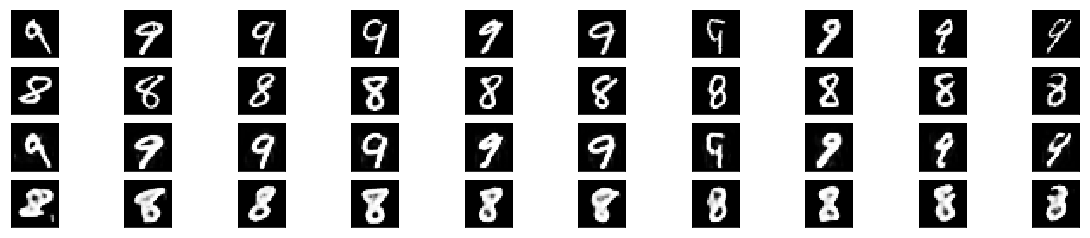

In [7]:
def show_imgs(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(4, n, i+1)
        plt.imshow(x_test[0][i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(4, n, i+1 +n)
        plt.imshow(x_test[1][i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, n, i+ 1 +2*n)
        plt.imshow(decoded_imgs[0][i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(4, n, i+ 1 +3*n)
        plt.imshow(decoded_imgs[1][i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()
    
decoded_imgs = autoencoder.predict([x_9_test, x_8_test])
show_imgs([x_9_test, x_8_test], decoded_imgs)

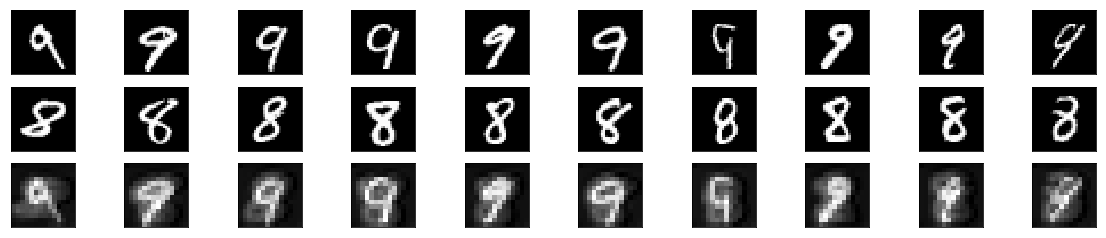

In [8]:
enbig1 = UpSampling2D(size=(2, 2))(encoded)
#enbig2 = UpSampling2D(size=(2, 2))(enbig1)

autoencoder_show_hidden = Model([input1_img, input2_img], enbig1)
encoded_imgs = autoencoder_show_hidden.predict([x_9_test, x_8_test])

def show_hidden(x_9_test, x_8_test, encoded_imgs, n=10):
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        plt.imshow(x_9_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i+1 +n)
        plt.imshow(x_8_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(3, n, i+1 +2*n)
            plt.imshow(encoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

show_hidden(x_9_test, x_8_test, encoded_imgs)

In [ ]:
input1_train2_autoencoder.summary()